In [1]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.preprocessing import OneHotEncoder
from neural_network_wrapper import NeuralNetworkWrapper
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
import optimizers

import json

In [2]:
data_simple_train_100 = pd.read_csv("./projekt1/classification/data.simple.train.100.csv")
data_simple_train_500 = pd.read_csv("./projekt1/classification/data.simple.train.500.csv")
data_simple_train_1000 = pd.read_csv("./projekt1/classification/data.simple.train.1000.csv")
data_simple_train_10000 = pd.read_csv("./projekt1/classification/data.simple.train.10000.csv")

data_simple_test_100 = pd.read_csv("./projekt1/classification/data.simple.test.100.csv")
data_simple_test_500 = pd.read_csv("./projekt1/classification/data.simple.test.500.csv")
data_simple_test_1000 = pd.read_csv("./projekt1/classification/data.simple.test.1000.csv")
data_simple_test_10000 = pd.read_csv("./projekt1/classification/data.simple.test.10000.csv")

In [3]:
def prepare_data_simple(train_data, test_data):
    
    X_train = np.array(train_data.loc[:, ['x', 'y']])
    y_train = train_data.cls
    y_train -= 1
    #one hot encoding
    y_ohc = np.zeros((y_train.size, int(np.max(y_train))+1))
    y_ohc[np.arange(y_train.size),y_train.astype(np.int)] = 1
    y_train = y_ohc
    
    X_test = np.array(test_data.loc[:, ['x', 'y']])
    y_test = test_data.cls
    y_test -= 1
    #one hot encoding
    y_ohc = np.zeros((y_test.size, int(np.max(y_test))+1))
    y_ohc[np.arange(y_test.size),y_test.astype(np.int)] = 1
    y_test = y_ohc
    
    
    # Are we supposed to use StandardScaler?
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    return {"X_train": X_train,
           "X_test": X_test,
           "y_train": y_train,
           "y_test": y_test}

In [4]:
data = [{"dataset name": "Data simple 100 obs",
        "data": prepare_data_simple(data_simple_train_100, data_simple_test_100)},
       {"dataset name": "Data simple 500 obs",
        "data": prepare_data_simple(data_simple_train_500, data_simple_test_500)},
       {"dataset name": "Data simple 1000 obs",
        "data": prepare_data_simple(data_simple_train_1000, data_simple_test_1000)},
       {"dataset name": "Data simple 10000 obs",
        "data": prepare_data_simple(data_simple_train_10000, data_simple_test_10000)}]

In [6]:
input_dim = 2
neuron_numbers = [4, 4, 2]
output_activation = ['sigmoid']
seed=42 #reproducibility
num_epochs=10
loss_function = 'logistic_loss'
learning_rate = 0.001

# Things we would like to test
activation_functions = ['relu', 'leaky_relu']
batch_size = 1#[2*(i+1) for i in range(5)]
optimizer_beta = [0, 0.5, 0.9] # 0 means no inertia


experiment_dict = {
    "input_dim" : input_dim,
    "neuron_numbers" : neuron_numbers, # number of neurons in consecutive layers
    "activation_functions" : activation_functions,
    "loss_function" : loss_function,
    "batch_size" : batch_size,
    "num_epochs" : num_epochs,
    "seed" : seed,
    "output_activation" : output_activation,
    "learning_rate" : learning_rate
}

In [7]:
def perform_experiment(dataset,
                       d,
                       exp_objective,
                       exp_values,
                       num_reps):
    """
    """
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']

    d = d.copy()
    
    for k in exp_values.keys():
        d[k] = {}
        d[k]['test_accuracy'] = []
    
    for i in range(num_reps):
        print(f"Experiment {i+1}/{num_reps}")
    
        # reproducibility issues
        random.seed(d['seed'] + i)
        np.random.seed(d['seed'] + i)
    
        # testing learning rate
        for k, v in exp_values.items():
            if exp_objective == 'lr':

                NN = NeuralNetworkWrapper(d['input_dim'],
                                      d['neuron_numbers'],
                                      ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                      d['loss_function'],
                                      v,
                                      optimizers.Optimizer(),
                                      d['batch_size'])
            
            elif exp_objective == 'activation_function':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          v * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.Optimizer(),
                                          d['batch_size'])
            
                
                
            NN.train(X_train,
                     y_train,
                     d['num_epochs'],
                     validation_split = 0,
                     test_accuracy=(X_test, y_test),
                     verbosity=False)
                
            d[k]['test_accuracy'].append(NN.test_accuracy)

    for k in exp_values.keys():
        # aggregating results
        d[k]['test_accuracy_mean'] = np.mean(np.array(d[k]['test_accuracy']).T, axis=1)
        d[k]['test_accuracy_std'] = np.std(np.array(d[k]['test_accuracy']).T, axis=1)

        d[k] = {"Accuracy": d[k]['test_accuracy_mean'],
               "Accuracy std": d[k]['test_accuracy_std'],
               "Best Accuracy": np.max(d[k]['test_accuracy_mean']),
               "Best Accuracy std": d[k]['test_accuracy_std'][np.argmax(d[k]['test_accuracy_mean'])]}

    return {k: d[k] for k in exp_values.keys()}


In [8]:
# perform_experiment(data[0]['data'],
#                    experiment_dict,
#                    'lr',
#                    {'lr=0.1' : 0.001,
#                    'lr=0.2' : 0.002},
#                   10)

perform_experiment(data[0]['data'],
                   experiment_dict,
                   'activation_function',
                   {'relu' : ['relu'],
                   'leaky relu' : ['leaky_relu']},
                  10)


Experiment 1/10
Final loss: 1.239
Final loss: 0.637
Experiment 2/10
Final loss: 0.649
Final loss: 1.111
Experiment 3/10
Final loss: 1.597
Final loss: 0.790
Experiment 4/10
Final loss: 1.143
Final loss: 1.007
Experiment 5/10
Final loss: 1.294
Final loss: 1.236
Experiment 6/10
Final loss: 1.462
Final loss: 0.725
Experiment 7/10
Final loss: 0.655
Final loss: 0.606
Experiment 8/10
Final loss: 0.585
Final loss: 1.207
Experiment 9/10
Final loss: 1.094
Final loss: 1.306
Experiment 10/10
Final loss: 1.387
Final loss: 1.345


{'relu': {'Accuracy': array([0.517, 0.537, 0.558, 0.594, 0.656, 0.684, 0.709, 0.729, 0.735,
         0.745]),
  'Accuracy std': array([0.06116371, 0.06812489, 0.08207314, 0.12690154, 0.1609472 ,
         0.1600125 , 0.16015305, 0.161149  , 0.15876083, 0.15932671]),
  'Best Accuracy': 0.7450000000000001,
  'Best Accuracy std': 0.15932670836994028},
 'leaky relu': {'Accuracy': array([0.579, 0.623, 0.656, 0.686, 0.703, 0.713, 0.725, 0.742, 0.762,
         0.787]),
  'Accuracy std': array([0.1100409 , 0.13000385, 0.1450655 , 0.15894653, 0.16775279,
         0.17303468, 0.17676255, 0.18015549, 0.16743954, 0.15152888]),
  'Best Accuracy': 0.7869999999999999,
  'Best Accuracy std': 0.15152887513606111}}

In [9]:
def experiments_pipeline(data,
                         experiment_dict,
                         num_reps=1,
                         save_to_file=False):
    """
    """
    d = experiment_dict.copy()
    output = {'lr':{},
             'activation_function':{},
             'inertia':{}}
    # Experiments for each dataset
    for dataset in data:
        
        output['lr'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                     experiment_dict,
                                                     'lr',
                                                     {'lr=0.00001' : 0.00001,
                                                      'lr=0.0001' : 0.0001,
                                                      'lr=0.001' : 0.001,
                                                      'lr=0.01' : 0.01},
                                                     num_reps)
        output['activation_function'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'activation_function',
                                                        {'relu' : ['relu'],
                                                        'leaky relu' : ['leaky_relu']},
                                                        num_reps)
        
        
    return output

In [10]:
ans = experiments_pipeline(data, experiment_dict, num_reps=5)

Experiment 1/5
Final loss: 1.677
Final loss: 1.617
Final loss: 1.299
Final loss: 0.116
Experiment 2/5
Final loss: 3.205
Final loss: 1.334
Final loss: 1.346
Final loss: 0.184
Experiment 3/5
Final loss: 2.945
Final loss: 1.338
Final loss: 1.654
Final loss: 0.301
Experiment 4/5
Final loss: 1.617
Final loss: 1.519
Final loss: 1.259
Final loss: 0.100
Experiment 5/5
Final loss: 2.442
Final loss: 1.906
Final loss: 1.006
Final loss: 0.091
Experiment 1/5
Final loss: 1.239
Final loss: 0.637
Experiment 2/5
Final loss: 0.649
Final loss: 1.111
Experiment 3/5
Final loss: 1.597
Final loss: 0.790
Experiment 4/5
Final loss: 1.143
Final loss: 1.007
Experiment 5/5
Final loss: 1.294
Final loss: 1.236
Experiment 1/5
Final loss: 1.563
Final loss: 0.869
Final loss: 0.460
Final loss: 0.108
Experiment 2/5
Final loss: 2.430
Final loss: 1.186
Final loss: 1.042


/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/loss_functions.py:5: RuntimeWarning: divide by zero encountered in log
  loss = (-1 / m) * (np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/loss_functions.py:5: RuntimeWarning: invalid value encountered in multiply
  loss = (-1 / m) * (np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/loss_functions.py:11: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(1 - y, 1 - y_hat) - np.divide(y, y_hat)
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:21: RuntimeWarning: invalid value encountered in greater
  derivative[Z > 0] = 1


Final loss: nan
Experiment 3/5
Final loss: 2.978
Final loss: 0.961
Final loss: 1.342
Final loss: 0.057
Experiment 4/5
Final loss: 1.558
Final loss: 1.221
Final loss: 0.899
Final loss: nan
Experiment 5/5
Final loss: 2.257
Final loss: 1.543
Final loss: 0.333
Final loss: nan
Experiment 1/5
Final loss: 0.526
Final loss: 0.241
Experiment 2/5
Final loss: 0.160
Final loss: 0.412
Experiment 3/5
Final loss: 1.185
Final loss: 0.174
Experiment 4/5
Final loss: 0.513
Final loss: 0.305
Experiment 5/5
Final loss: 0.335
Final loss: 0.241
Experiment 1/5
Final loss: 1.514
Final loss: 0.676
Final loss: 0.163
Final loss: nan
Experiment 2/5
Final loss: 1.892
Final loss: 1.104
Final loss: 0.451
Final loss: nan
Experiment 3/5
Final loss: 2.755
Final loss: 0.733
Final loss: 0.719
Final loss: nan
Experiment 4/5
Final loss: 1.511
Final loss: 1.054
Final loss: 0.330
Final loss: nan
Experiment 5/5
Final loss: 2.200
Final loss: 1.295
Final loss: 0.151
Final loss: nan
Experiment 1/5
Final loss: 0.157
Final loss: 0.

/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:26: RuntimeWarning: invalid value encountered in greater
  Z = ((Z > 0) * Z) + ((Z < 0) * Z * 0.01)
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:26: RuntimeWarning: invalid value encountered in less
  Z = ((Z > 0) * Z) + ((Z < 0) * Z * 0.01)
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:32: RuntimeWarning: invalid value encountered in greater
  derivative[Z > 0] = 1
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:33: RuntimeWarning: invalid value encountered in less
  derivative[Z < 0] = 0.01


Final loss: nan
Experiment 2/5
Final loss: nan
Final loss: nan
Experiment 3/5
Final loss: nan
Final loss: nan
Experiment 4/5
Final loss: 0.050
Final loss: nan
Experiment 5/5
Final loss: nan
Final loss: nan


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white")
#sns.despine(left=True, bottom=True)

plt.style.use('bmh')
# Available matplotlib styles:
# ['seaborn-colorblind', 'fast', 'seaborn-deep', 'fivethirtyeight', 'seaborn',
#  'Solarize_Light2', 'seaborn-talk', 'seaborn-darkgrid', 'ggplot', 'seaborn-bright',
#  'seaborn-paper', 'seaborn-pastel', 'bmh', 'seaborn-dark', 'seaborn-notebook',
#  'tableau-colorblind10', 'seaborn-white', '_classic_test', 'seaborn-ticks',
#  'seaborn-poster', 'seaborn-muted', 'dark_background', 'grayscale',
#  'seaborn-dark-palette', 'seaborn-whitegrid', 'classic']

def visualize_experiment(d, title="", figsize=(21, 12)):
    
    fig, a = plt.subplots(2, 2)
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    dataset_names = list(d.keys())
    
    fig.suptitle(title, fontsize=30)
    
    counter = 0
    for i in range(2):
        for j in range(2):
            
            subplot_dict = d[dataset_names[counter]]
            
            a[i][j].title.set_text(f'Accuracy in {dataset_names[counter]}')
            a[i][j].set_ylim((0, 1))
            a[i][j].set_xticks(range(1, 1 + len(subplot_dict[list(subplot_dict.keys())[0]]['Accuracy'])))
            
            for k, v in subplot_dict.items():
                a[i][j].plot([it+1 for it in range(len(v['Accuracy']))], v['Accuracy'], label=k)
                
                a[i][j].legend(loc="upper left")
            
            counter += 1
    
    plt.show()

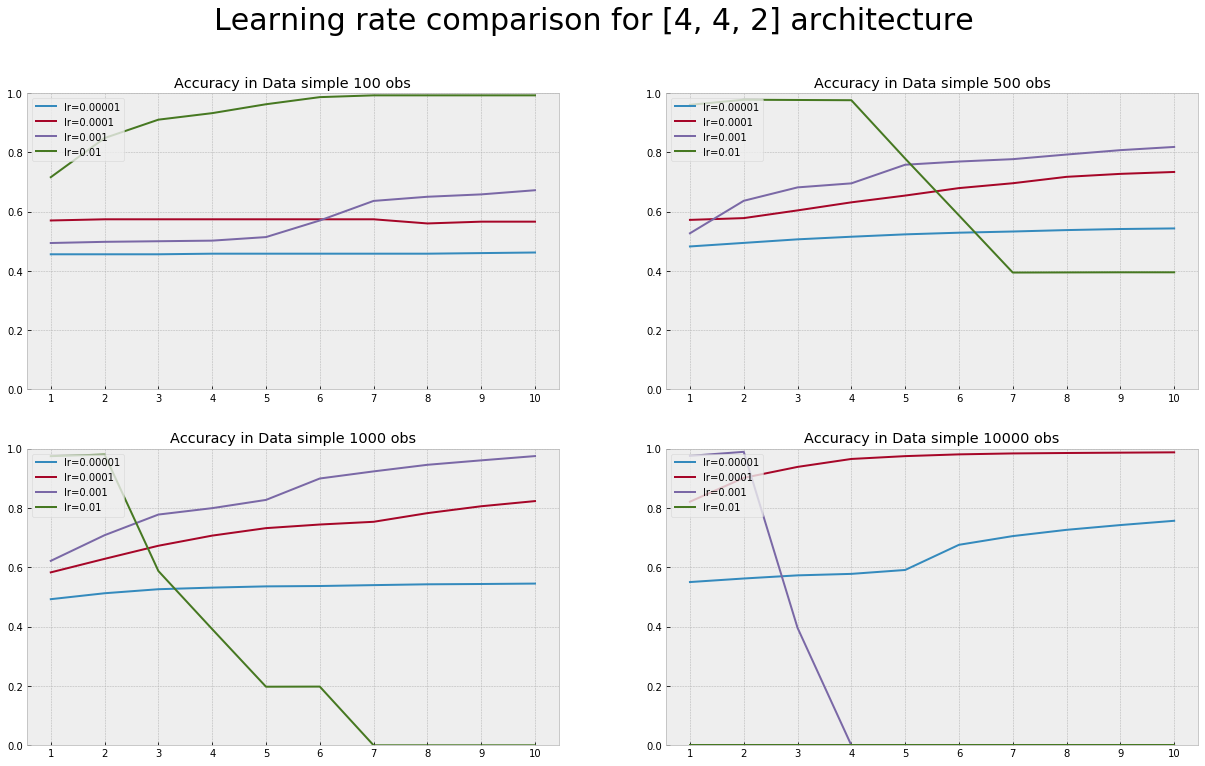

In [12]:
visualize_experiment(ans['lr'],
                     title='Learning rate comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

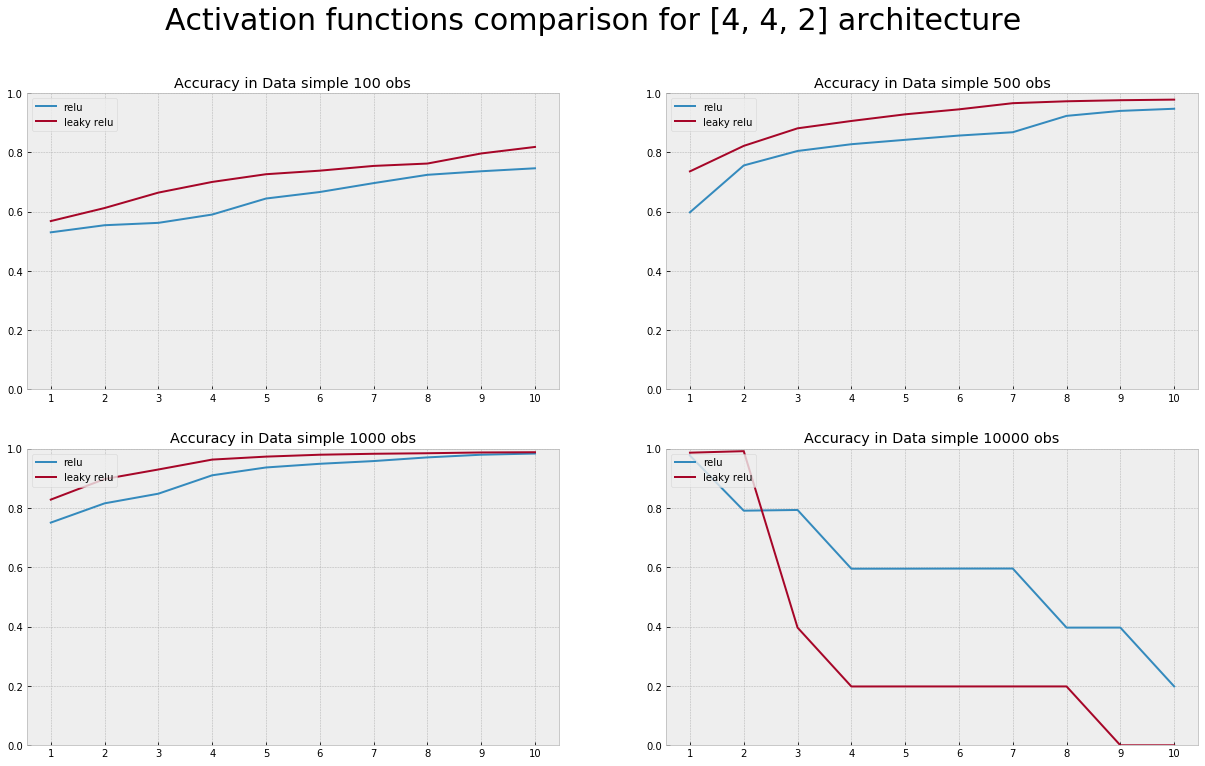

In [13]:
visualize_experiment(ans['activation_function'],
                     title='Activation functions comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))